## Домашняя работа №8

Реализовать синтезирование лиц из LFW с помощью DCGAN.
Библиотеки: [Python, Tensorflow].

### Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

### Загрузка и подготовка датасета LFW

In [3]:
if 1:
  train_ds, info_ds = tfds.load(
      'lfw',
      as_supervised=True,
      with_info=True,
      split='train'
  )

In [4]:
info_ds

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

### Визуализация датасета LFW

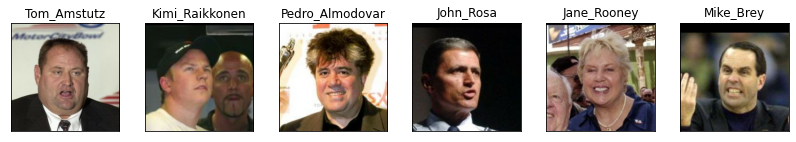

In [5]:
samples = [[x[0], x[1]] for x in iter(train_ds.take(6))]

fig = plt.figure(figsize=(14,14))

for i in range(len(samples)):
  ax = fig.add_subplot(6,6, i+1)
  ax.set_title(samples[i][0].numpy().decode('UTF-8'))
  ax.imshow(samples[i][1])
  plt.xticks([]), plt.yticks([])

plt.show()

### Deep Convolutional GAN (DCGAN)

In [6]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),   
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),        
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

### Подготовка пайплайна данных

In [7]:
INPUT_DIM = 100
NUM_EPOCHS = 15
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

In [8]:
def prepare(label, img):
    img = tf.image.resize(img, [224, 224])
    return label, (tf.cast(img, tf.float32)- 127.5) / 127.5

In [9]:
train_ds = train_ds.shuffle(buffer_size=11000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [10]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Обучение DCGAN

In [11]:
def plot_image(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        img = (samples[j, ...] * 127.5) + 127.5
        img = (tf.cast(img, tf.int16))
        ax.imshow(img)
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.9709; G Loss: 0.4671


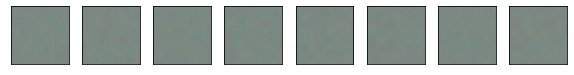

[Step 1000] D Loss: 9.0870; G Loss: 4.2835


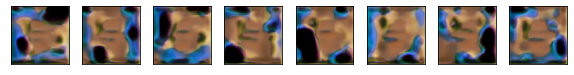

[Step 2000] D Loss: 1.2020; G Loss: 14.0379


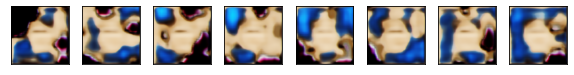

[Step 3000] D Loss: 0.7866; G Loss: 1.9595


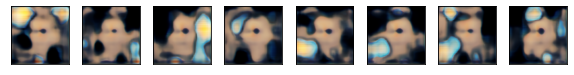

[Step 4000] D Loss: 0.4376; G Loss: 6.4440


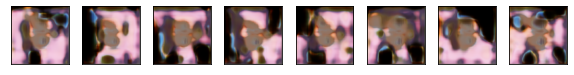

[Step 5000] D Loss: 1.2359; G Loss: 8.0857


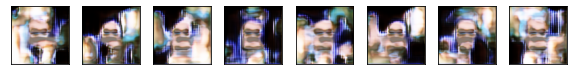

[Step 6000] D Loss: 2.3333; G Loss: 9.0207


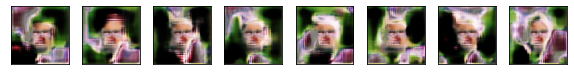

[Step 7000] D Loss: 1.6418; G Loss: 8.7124


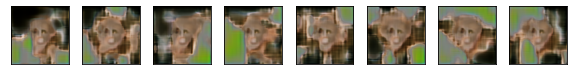

[Step 8000] D Loss: 1.5864; G Loss: 13.5935


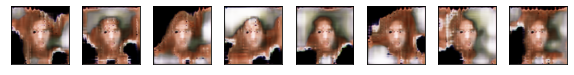

[Step 9000] D Loss: 0.5120; G Loss: 3.8831


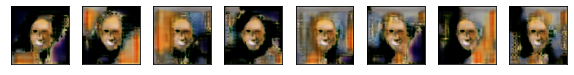

[Step 10000] D Loss: 0.0037; G Loss: 7.5094


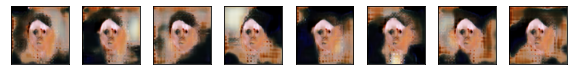

[Step 11000] D Loss: 0.4294; G Loss: 14.4581


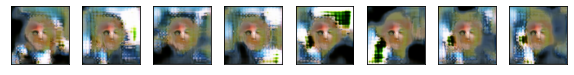

[Step 12000] D Loss: 0.1297; G Loss: 11.7550


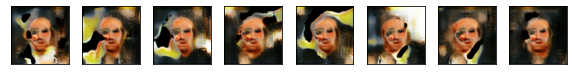

CPU times: user 38min 42s, sys: 5min 22s, total: 44min 5s
Wall time: 1h 30min 22s


In [12]:
%%time

for step, (_, true_images) in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_image(syntetic_images)

### Тестирование свёрточного генератора

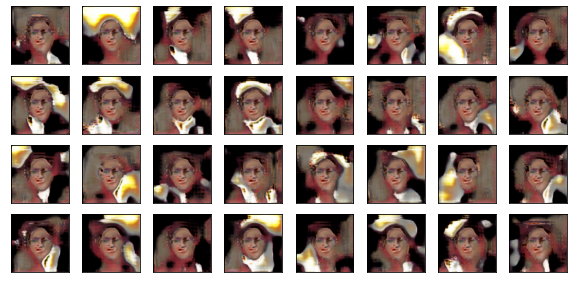

In [13]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_image(syntetic_images)

### Интерполяция в латентном пространстве

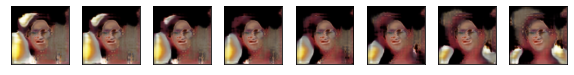

In [14]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_image(syntetic_images)